# Modeling

## Import and Load

In [24]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import (train_test_split, StratifiedKFold,
                                     StratifiedShuffleSplit, cross_validate,
                                     cross_val_predict, GridSearchCV)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
roc_curve, roc_auc_score, make_scorer, precision_score, confusion_matrix)

import xgboost as xgb

In [25]:
pd.set_option('display.max_rows',100)
pd.set_option('display.max_columns', None)

In [26]:
df = pd.read_pickle('featured_df.pkl')

## Features

In [27]:
def generate_percentiles(columns, percentile):
    for index, column in enumerate(columns, start=1):
        df['c{}_p{}'.format(index, percentile)] = \
        df[column].apply(lambda x: np.percentile(x, percentile))
    return df

df = generate_percentiles(['ch_%02d' % i for i in range(1,17)],99)

## Train/Test Splits

In [28]:
r = np.random.RandomState(0)
p_train = r.choice(np.arange(1,98),replace=False,size=(63))
i_train = r.choice(np.arange(1,805),replace=False,size=(516))

train = df[((df['sequence'].isin(p_train)) & (df['target']=='preictal'))
           | ((df['sequence'].isin(i_train)) & (df['target']=='interictal'))]
test = df[((~df['sequence'].isin(p_train)) & (df['target']=='preictal'))
           | ((~df['sequence'].isin(i_train)) & (df['target']=='interictal'))]
# if necessary you can store the old index as a column, but it needs to be
# removed from feature consideration
train, test = train.reset_index(drop=True), test.reset_index(drop=True)

In [29]:
channels = ['ch_01', 'ch_02', 'ch_03', 'ch_04', 'ch_05', 'ch_06', 'ch_07',
                   'ch_08','ch_09', 'ch_10', 'ch_11', 'ch_12', 'ch_13', 'ch_14',
                   'ch_15', 'ch_16']
non_X_cols = channels + ['sequence','target','target_bin']

X_train, y_train = train.drop(non_X_cols, axis=1), train['target_bin']
X_test, y_test = test.drop(non_X_cols, axis=1), test['target_bin']

## XGBoost

In [30]:
xgb_train = xgb.DMatrix(X_train, label=y_train)

gbm = xgb.XGBClassifier(n_jobs=-1,
                        n_estimators=30000,
                       max_depth=11,
                       learning_rate=0.05,
                       subsample=0.5,
                       scale_pos_weight=5,
                       min_child_weight=1,
                       colsample_bytree=1 # as I perform feature selection maybe this should change
                      )

xgb_params = gbm.get_xgb_params()

cv_result = xgb.cv(params=xgb_params,
                   dtrain=xgb_train,
                   metrics=('auc'),
                   stratified=True, nfold=3, shuffle=True, seed=0,
                   num_boost_round=30000, early_stopping_rounds=50
                  )
gbm.set_params(n_estimators=cv_result.shape[0])
cv_result.tail(1)

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
708,0.949431,0.00347,1.0,0.0


**Get validation predictions for ensemble model**

In [31]:
def make_folds(X_train, y_train):
    
    folds = []
    sfolds = StratifiedKFold(3, shuffle=True, random_state=0)
    for train_index, test_index in sfolds.split(X_train, y_train):
        folds.append((train_index, test_index))
        
    return folds

In [32]:
def get_xgb_preds(X, y):
    
    xgb_preds = []
    preds_index = []
    folds = make_folds(X, y)
    for fold in folds:
        gbm.fit(X=X.loc[fold[0],:],
                y=y.loc[fold[0]],
                eval_set=[(X.loc[fold[1],:],
                          y.loc[fold[1]])],
                eval_metric='auc',
                early_stopping_rounds=50,
                verbose=False
               )
        predictions = gbm.predict_proba(X.loc[fold[1],:])[:,1]
        xgb_preds.extend(predictions)
        preds_index.extend(fold[1])
    
    df = pd.DataFrame(xgb_preds, index=preds_index, columns=['xgb_preds'])
    return df.sort_index()

xgb_pred = get_xgb_preds(X_train, y_train)

**Final Fitting**

In [33]:
gbm.fit(X_train, y_train, eval_metric='auc')
xgb_preds = gbm.predict(X_train)
precision_recall_fscore_support(y_train, xgb_preds)

(array([ 1.,  1.]),
 array([ 1.,  1.]),
 array([ 1.,  1.]),
 array([20124,  2457]))

### Feature Selection

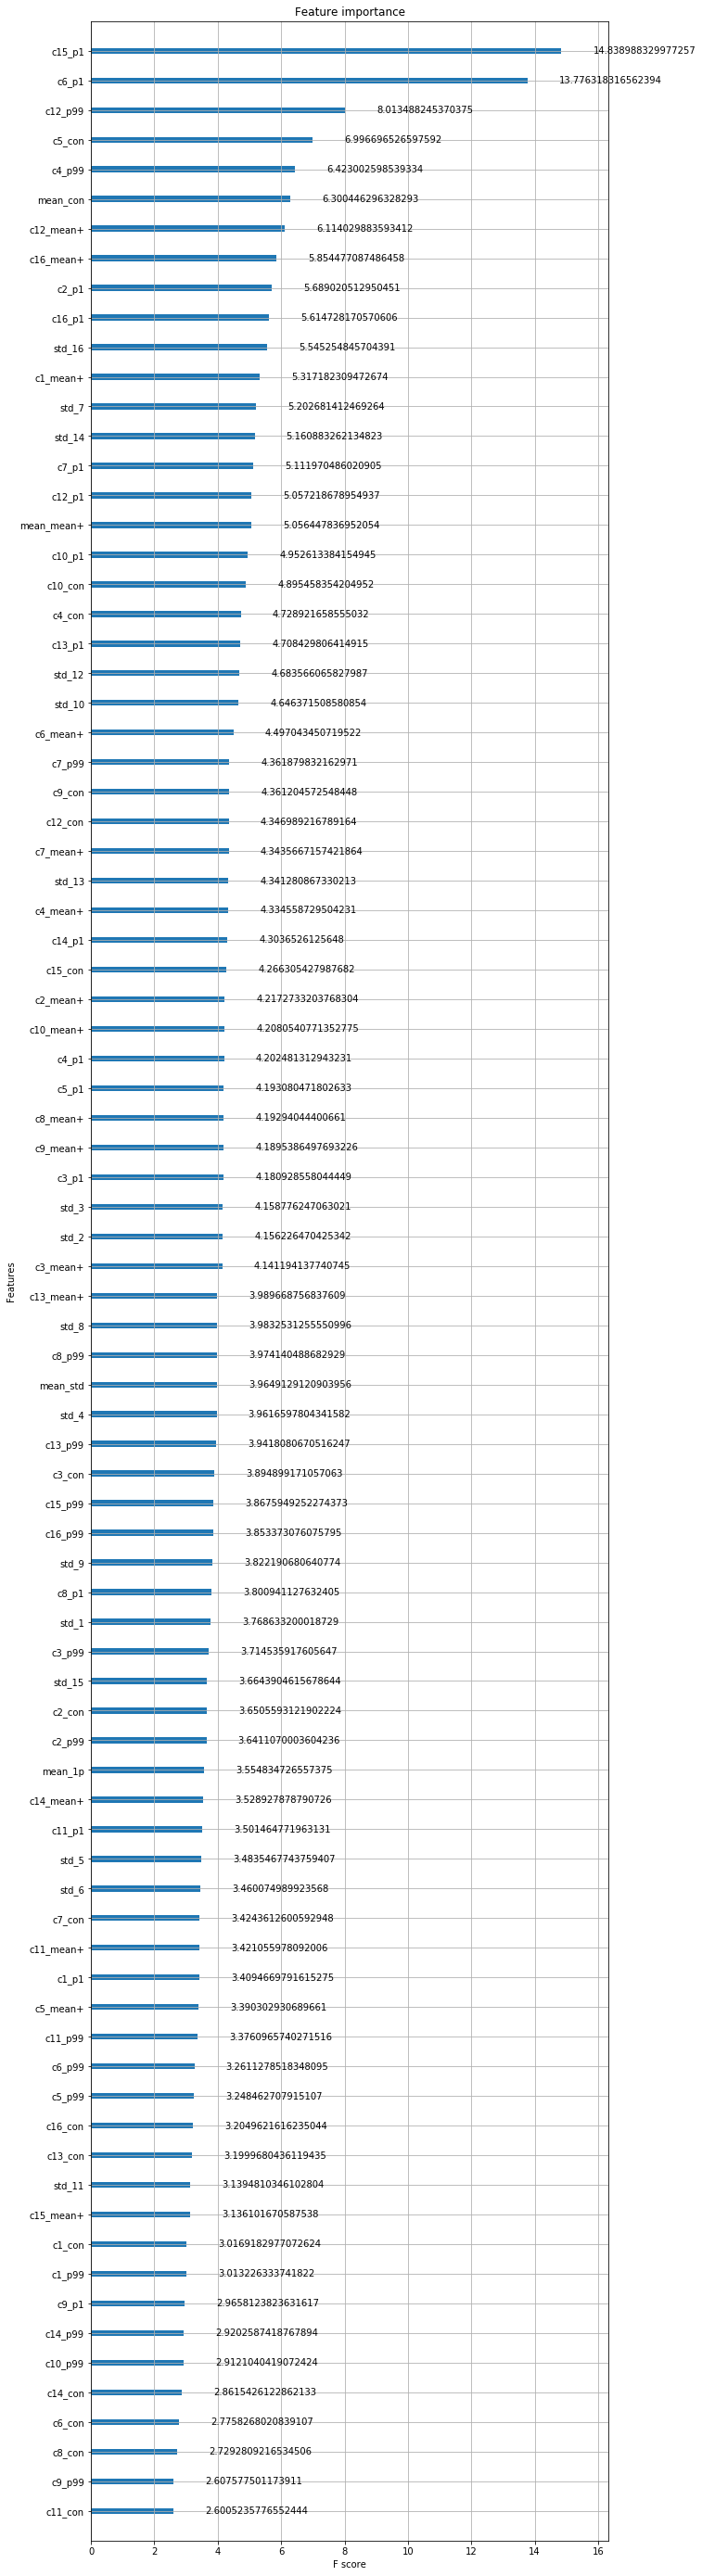

In [34]:
fig, axes = plt.subplots(figsize=(10,50))
xgb.plot_importance(gbm, importance_type='gain', ax=axes);

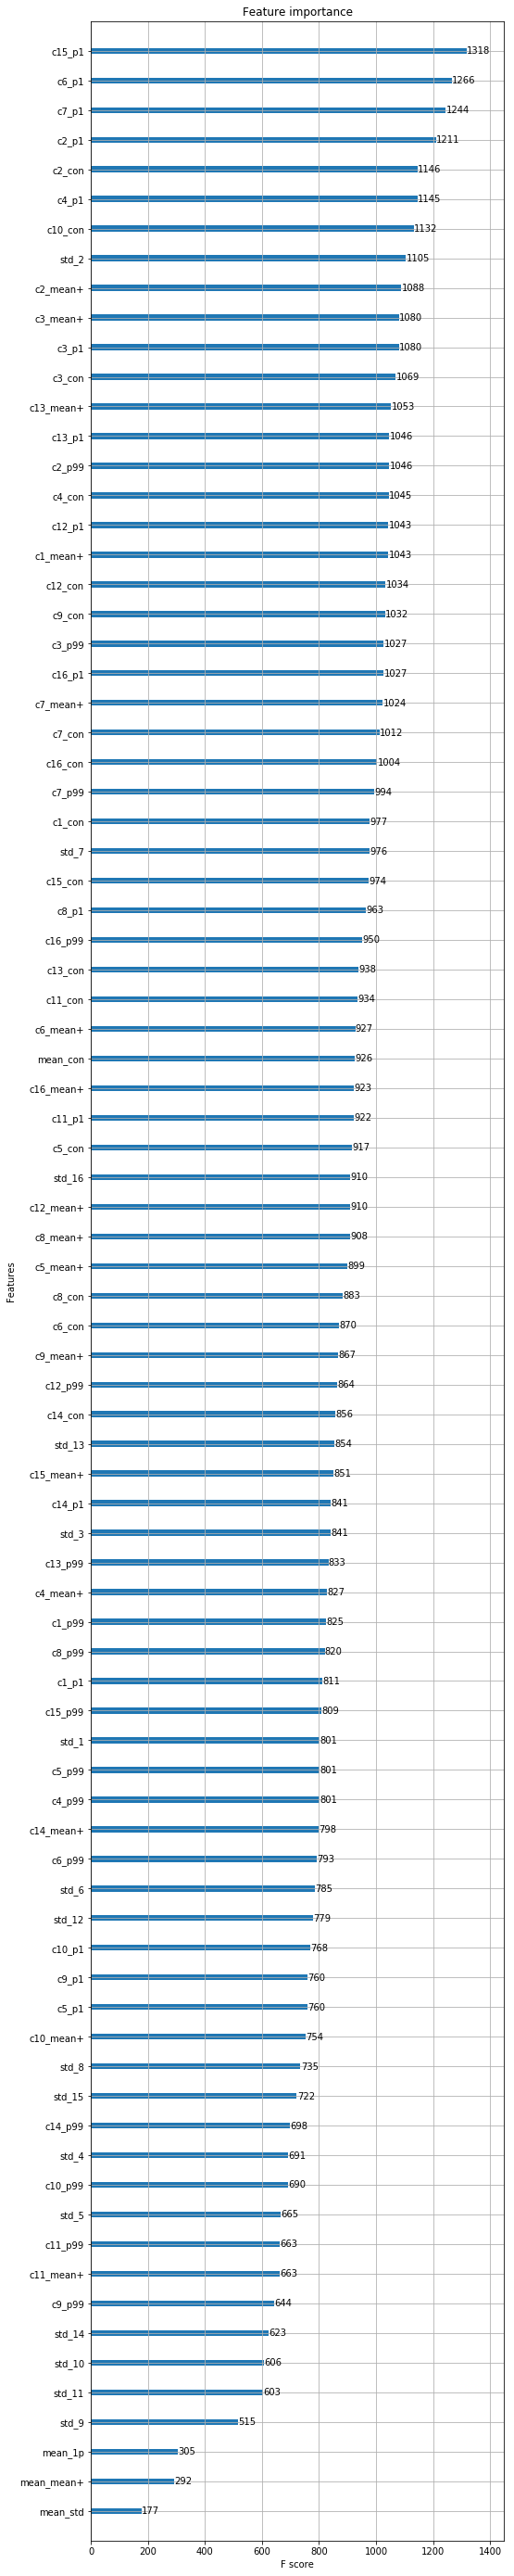

In [35]:
fig, axes = plt.subplots(figsize=(8,50))
xgb.plot_importance(gbm, ax=axes);

### XGBoost Heatmap

In [36]:
tn, fp, fn, tp = confusion_matrix(y_train, [0 if i < 0.5 else 1 for i in xgb_pred.values]).ravel() # outputs an array w/o ravel

conf_matrix = [[(tp/(tp + fn)),(tn/(tn + fp))],
               [(tp/(tp + fp)),(tn/(tn + fn))]]

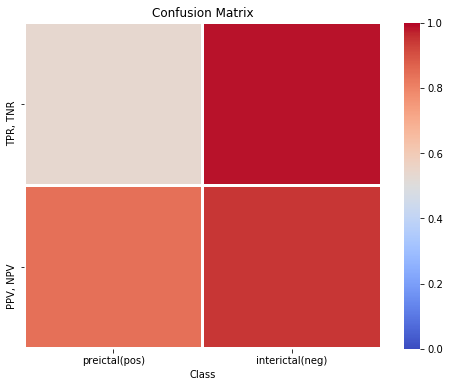

In [37]:
fig, axes = plt.subplots(figsize=(8,6))
sns.heatmap(conf_matrix, cmap='coolwarm', lw=2, ax=axes,
           xticklabels=['preictal(pos)','interictal(neg)'],
           yticklabels=['TPR, TNR','PPV, NPV'],
           vmin=0,
           vmax=1)
axes.set(xlabel='Class',
        title='Confusion Matrix');

## Meta Analysis

In [38]:
def shape_probabilities(xgb_preds):
    """Generate probabilities for each 15s interval and return
    as an array with a column for each 15s interval.
    """
    xgb_preds = xgb_preds['xgb_preds'].values
    xgb_preds = xgb_preds.reshape(len(xgb_preds)//39,39)
    return xgb_preds

In [39]:
def collapse_df(df, xgb_preds):
    
    collapsed = df.iloc[::39, :]
    collapsed = collapsed.filter(['sequence','target','target_bin'])

    xgb_preds = pd.DataFrame(shape_probabilities(xgb_preds),
                            columns=['p_trial_{}'.format(i) for i in range(39)],
                            index=collapsed.index)

    collapsed = pd.concat([collapsed, xgb_preds],
                                axis=1)
    return collapsed

In [40]:
def xgb_features(collapsed, xgb_columns):
    recents = xgb_columns[20:]
    
    collapsed['mean'] = (collapsed.filter(xgb_columns, axis=1)
                         .mean(axis=1))
    collapsed['r_mean'] = (collapsed.filter(recents, axis=1)
                         .mean(axis=1))
    # mean of 9 largest values
    collapsed['n_mean'] = (collapsed_train[xgb_columns]
                           .apply(lambda x: np.mean(sorted(x)[20:]), axis=1))
    collapsed['std'] = (collapsed.filter(xgb_columns, axis=1)
                        .std(axis=1))
    collapsed['max'] = (collapsed.filter(xgb_columns, axis=1)
                        .max(axis=1))
    return collapsed

In [41]:
xgb_columns = ['p_trial_{}'.format(i) for i in range(1,39)]
collapsed_train = collapse_df(train, xgb_pred)
collapsed_train = xgb_features(collapsed_train, xgb_columns)

### Validation Testing
**This you might be able to do with a built in function since the DF is already collapsed...**

In [42]:
log_mod = LogisticRegression(class_weight={1:4, 0:1})
params = {'C': np.arange(1,20)}
folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
grid = GridSearchCV(log_mod,
                    param_grid=params,
                    cv=folds,
                    scoring=['roc_auc','recall','precision','f1'],
                    refit='f1',
                    n_jobs=-1,
                    return_train_score=True)
grid.fit(X=collapsed_train[['n_mean','std']], y=collapsed_train['target_bin'])
print('roc_auc:', grid.cv_results_['mean_test_roc_auc'])
print('recall:', grid.cv_results_['mean_test_recall'])
print('precision:', grid.cv_results_['mean_test_precision'])
print('f1:', grid.cv_results_['mean_test_f1'])

roc_auc: [ 0.99492433  0.99492433  0.99492433  0.99492433  0.99492433  0.99492433
  0.99492433  0.99492433  0.99492433  0.99492433  0.99492433  0.99492433
  0.99492433  0.99492433  0.99492433  0.99492433  0.99492433  0.99492433
  0.99492433]
recall: [ 0.92063492  0.92063492  0.92063492  0.92063492  0.92063492  0.92063492
  0.92063492  0.92063492  0.92063492  0.92063492  0.92063492  0.92063492
  0.92063492  0.92063492  0.92063492  0.92063492  0.92063492  0.92063492
  0.92063492]
precision: [ 0.95382395  0.93939394  0.92621871  0.91414141  0.9030303   0.9030303
  0.9030303   0.9030303   0.9030303   0.9030303   0.9030303   0.9030303
  0.9030303   0.9030303   0.9030303   0.9030303   0.9030303   0.9030303
  0.9030303 ]
f1: [ 0.93523014  0.92784735  0.92080013  0.91406612  0.9076249   0.9076249
  0.9076249   0.9076249   0.9076249   0.9076249   0.9076249   0.9076249
  0.9076249   0.9076249   0.9076249   0.9076249   0.9076249   0.9076249
  0.9076249 ]


### Final Test

In [43]:
xgb_t_preds = get_xgb_preds(X_test, y_test)
collapsed_test = collapse_df(test, xgb_t_preds)
collapsed_test = xgb_features(collapsed_test, xgb_columns)
y_true = collapsed_test['target_bin']

log_pred = grid.best_estimator_.predict(collapsed_test[['n_mean', 'max']])
roc_auc_score(y_true, log_pred), precision_recall_fscore_support(y_true, log_pred)

(0.94097222222222221,
 (array([ 1. ,  0.5]),
  array([ 0.88194444,  1.        ]),
  array([ 0.93726937,  0.66666667]),
  array([288,  34])))

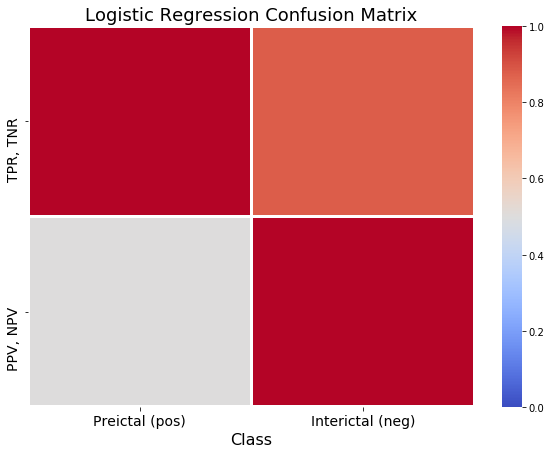

In [44]:
tn, fp, fn, tp = confusion_matrix(y_true, log_pred).ravel() # outputs an array w/o ravel

conf_matrix = [[(tp/(tp + fn)),(tn/(tn + fp))],
               [(tp/(tp + fp)),(tn/(tn + fn))]]

fig, axes = plt.subplots(figsize=(10,7))
sns.heatmap(conf_matrix, cmap='coolwarm', lw=2, ax=axes, vmin=0, vmax=1)

axes.set_xticklabels(['Preictal (pos)','Interictal (neg)'], fontsize=14)
axes.set_yticklabels(['TPR, TNR','PPV, NPV'], fontsize=14)
axes.set_xlabel('Class', fontsize=16)
axes.set_title('Logistic Regression Confusion Matrix', fontsize=18);

In [45]:
roc_auc_score(y_test, xgb_t_preds), precision_recall_fscore_support(y_test, [0 if i < 0.5 else 1 for i in xgb_t_preds.values])

(0.93157592452935589,
 (array([ 0.9436764 ,  0.79285714]),
  array([ 0.98450855,  0.50226244]),
  array([ 0.96366013,  0.61495845]),
  array([11232,  1326])))

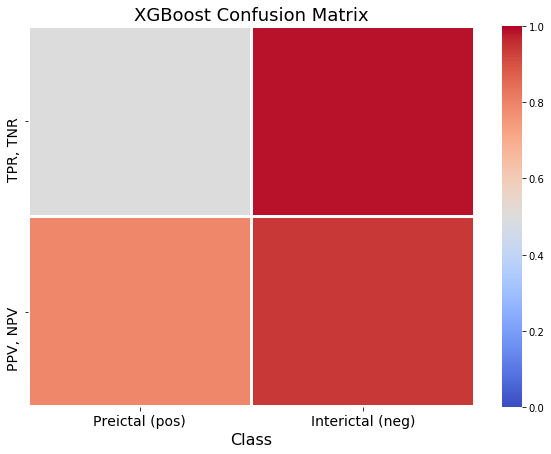

In [46]:
tn, fp, fn, tp = confusion_matrix(y_test, [0 if i < 0.5 else 1 for i in xgb_t_preds.values]).ravel() # outputs an array w/o ravel

conf_matrix = [[(tp/(tp + fn)),(tn/(tn + fp))],
               [(tp/(tp + fp)),(tn/(tn + fn))]]

fig, axes = plt.subplots(figsize=(10,7))
sns.heatmap(conf_matrix, cmap='coolwarm', lw=2, ax=axes, vmin=0, vmax=1)

axes.set_xticklabels(['Preictal (pos)','Interictal (neg)'], fontsize=14)
axes.set_yticklabels(['TPR, TNR','PPV, NPV'], fontsize=14)
axes.set_xlabel('Class', fontsize=16)
axes.set_title('XGBoost Confusion Matrix', fontsize=18);